In [ ]:
! unzip -q '/content/drive/MyDrive/staple crops dataset 2.zip' -d './'

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Clear session to avoid clutter
tf.keras.backend.clear_session()

In [ ]:
# Data augmentation layer with more augmentations
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [ ]:
# Hyperparameters
BATCH_SIZE = 32  # Increase the batch size if memory permits
IMAGE_SIZE = 224  # EfficientNetB0 input size
CHANNELS = 3
EPOCHS = 50
n_classes = 8  # Assuming 8 classes in your dataset

# Define the input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/staple crops dataset",  # Adjust the path
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8552 files belonging to 8 classes.


In [ ]:
# Splitting the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# Cache and prefetch datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Data augmentation layer with more aggressive augmentations
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   # Randomly flip images horizontally and vertically
    layers.RandomRotation(0.2),                     # Randomly rotate images by up to 20%
    layers.RandomZoom(0.2),                         # Randomly zoom images
    layers.RandomTranslation(0.2, 0.2),             # Randomly translate images by up to 20% in height and width
    layers.RandomContrast(0.2),                     # Randomly adjust contrast
    layers.RandomBrightness(0.2),                   # Randomly adjust brightness
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [ ]:
# Build the EfficientNetB0 model
base_model = EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                            include_top=False,  # Exclude final classification layer
                            weights='imagenet')  # Use pretrained weights


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Freeze the base model to retain pre-learned features
base_model.trainable = False

In [ ]:
# Fine-tuning strategy: Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [ ]:
# Define the model
model = models.Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,  # Add data augmentation
    base_model,  # Pre-trained EfficientNetB0 model
    layers.GlobalAveragePooling2D(),  # Replace Flatten with GlobalAveragePooling2D
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(n_classes, activation='softmax')  # Output layer
])

In [ ]:
# Compile the model with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',  # Suitable for integer labels
              metrics=['accuracy'])


In [ ]:
# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,571 (16.08 MB)

 Trainable params: 1,515,960 (5.78 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 194s 741ms/step - accuracy: 0.3929 - loss: 1.6489 - val_accuracy: 0.8041 - val_loss: 0.6270
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 138s 643ms/step - accuracy: 0.7163 - loss: 0.7798 - val_accuracy: 0.8534 - val_loss: 0.4651
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 137s 640ms/step - accuracy: 0.7776 - loss: 0.6309 - val_accuracy: 0.8690 - val_loss: 0.3863
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 140s 652ms/step - accuracy: 0.7955 - loss: 0.5552 - val_accuracy: 0.8522 - val_loss: 0.3981
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 138s 643ms/step - accuracy: 0.8260 - loss: 0.4820 - val_accuracy: 0.8774 - val_loss: 0.3464
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 136s 635ms/step - accuracy: 0.8342 - loss: 0.4545 - val_accuracy: 0.8678 - val_loss: 0.3731
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 138s 644ms/step - accuracy: 0.8567 - loss: 0.4142 - val_accuracy: 0.8906 - val_loss: 0.3088
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 138s 641ms/step - accuracy: 0.8629 -

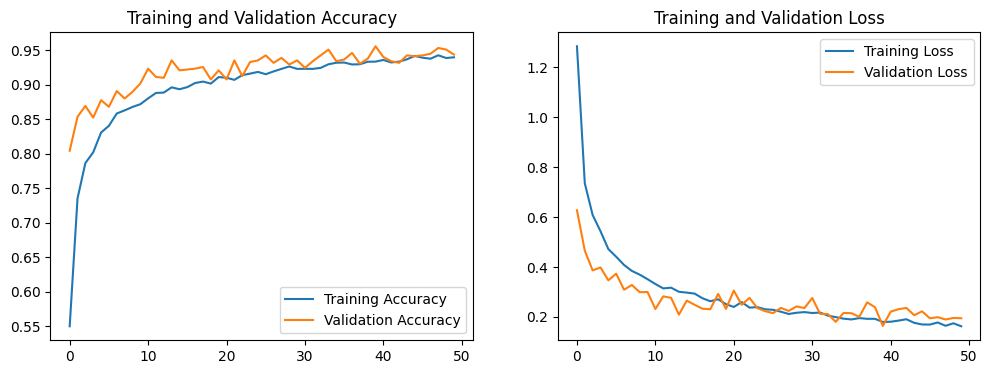

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Evaluate on the test set after training
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
import os

def save_model_to_drive(model, drive_path="MyDrive/saved_model"):
    # Define the complete path to save the model in Google Drive with a .keras extension
    save_path = f"/content/drive/{drive_path}.keras"

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the model
    model.save(save_path)
    print(f"Model saved to Google Drive at: {save_path}")


In [ ]:
save_model_to_drive(model, "MyDrive/saved_model/staple_crops_model")


Model saved to Google Drive at: /content/drive/MyDrive/saved_model/staple_crops_model.keras


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf  # Make sure to import TensorFlow

# Function to predict the class of a single image
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # No need for .numpy() here
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [ ]:
# Define class names (replace these with your actual class names)
class_names = [
    'Potato__bacterial_wilt',
    'Potato_early_blight',
    'Potato_healthy',
    'Potato_late_bligh',
    'Potato_nematode',
    'Potato_pests',
    'Potato_phytophthora',
    'Potato__virus'
]


In [ ]:
# Randomly select 9 images from the test dataset
num_images_to_display = 9
# Get the number of images in the test dataset
test_size = tf.data.experimental.cardinality(test_ds).numpy()

# Randomly select indices
random_indices = random.sample(range(test_size), num_images_to_display)

plt.figure(figsize=(15, 15))
for idx in random_indices:
    images, labels = next(iter(test_ds.skip(idx)))  # Skip to the randomly selected index

    for i in range(min(len(images), num_images_to_display)):  # Ensure we don't go out of bounds
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])  # Pass images[i] directly
        actual_class = class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Get predictions from the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    # Append true labels
    y_true.extend(labels.numpy())

    # Get predictions
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

F1 Score: 0.9578


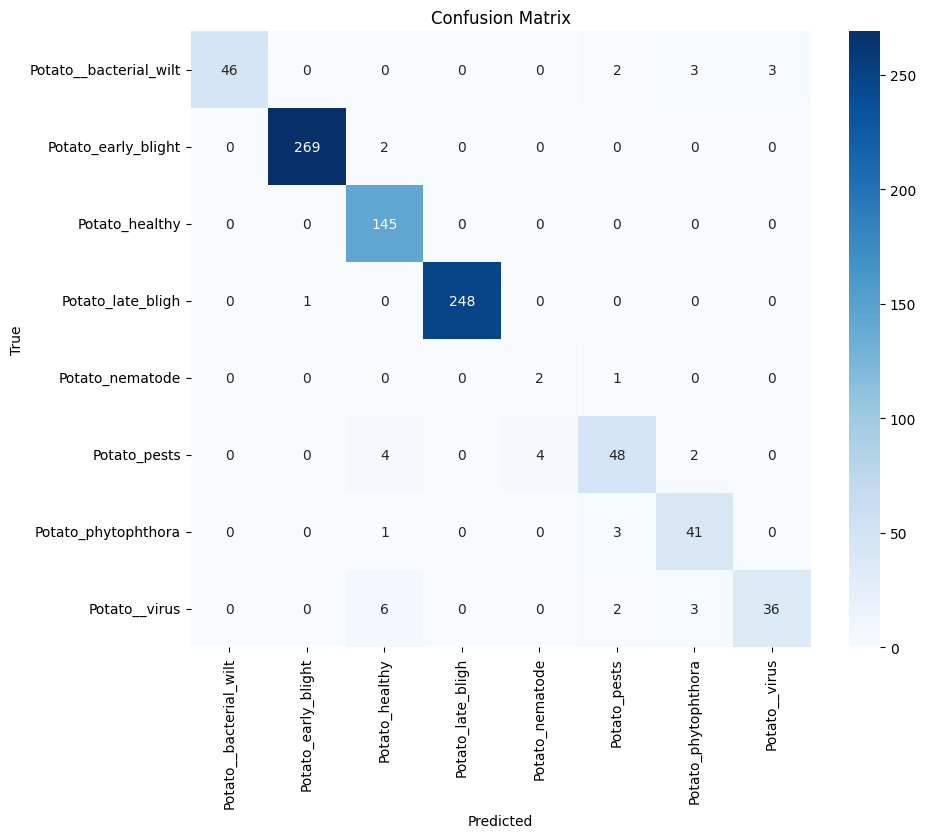

In [ ]:
# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
